In [ ]:
# === 1. Mount Drive & Imports ===
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Define Paths & Load Metadata
BASE_DIR  = '/content/drive/MyDrive/icici_w5-8'
CSV_PATH  = os.path.join(BASE_DIR, 'imdb_images_metadata.csv')

# Load CSV
df = pd.read_csv(CSV_PATH)

# Use the provided age column as our ground-truth
df['true_age'] = df['age']

# Build full image paths
df['img_path'] = df['full_path'].apply(lambda p: os.path.join(BASE_DIR, p))

# Quick sanity check
print(df[['filename','identity','photo_year','true_age','img_path']].head())

                                    filename   identity  photo_year  true_age  \
0  nm1343600_rm409832704_1978-12-20_2004.jpg  nm1343600        2004      25.5   
1  nm1343600_rm207985152_1978-12-20_2003.jpg  nm1343600        2003      24.5   
2  nm1343600_rm241539584_1978-12-20_2003.jpg  nm1343600        2003      24.5   
3   nm0451600_rm3884361984_1955-3-7_2012.jpg  nm0451600        2012      57.3   
4   nm0451600_rm1547153152_1955-3-7_2012.jpg  nm0451600        2012      57.3   

                                            img_path  
0  /content/drive/MyDrive/icici_w5-8/nm1343600_rm...  
1  /content/drive/MyDrive/icici_w5-8/nm1343600_rm...  
2  /content/drive/MyDrive/icici_w5-8/nm1343600_rm...  
3  /content/drive/MyDrive/icici_w5-8/nm0451600_rm...  
4  /content/drive/MyDrive/icici_w5-8/nm0451600_rm...  


In [ ]:
# === 4. Install & Import Pre-trained Models ===
!pip install facenet-pytorch deepface

from facenet_pytorch import InceptionResnetV1, MTCNN
from deepface import DeepFace
import torch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

# FaceNet setup
mtcnn   = MTCNN(image_size=160, margin=0, keep_all=False).eval()
resnet  = InceptionResnetV1(pretrained='vggface2').eval()

In [ ]:
# === 5. Age-Estimation Inference Loop ===

y_true_age = []
y_pred_age = []

for _, row in df.iterrows():
    img_bgr = cv2.imread(row['img_path'])
    if img_bgr is None:
        continue

    # Convert BGR → RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # DeepFace age estimation (uses its own detector)
    try:
        analysis = DeepFace.analyze(
            img_rgb,
            actions=['age'],
            detector_backend='opencv',
            enforce_detection=False
        )
    except Exception as e:
        # skip images that still error out
        print(f"Skipping {row['filename']} due to {e}")
        continue

    # analysis may be a list if multiple faces; take the first result
    age_pred = analysis[0]['age'] if isinstance(analysis, list) else analysis['age']

    y_pred_age.append(age_pred)
    y_true_age.append(row['true_age'])

print(f"Processed {len(y_pred_age)} / {len(df)} images for age estimation")

Processed 127 / 127 images for age estimation


Mean Absolute Error (MAE): 15.85 years


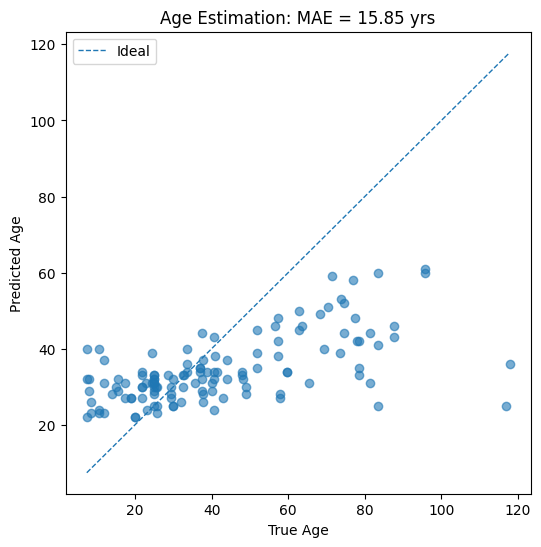

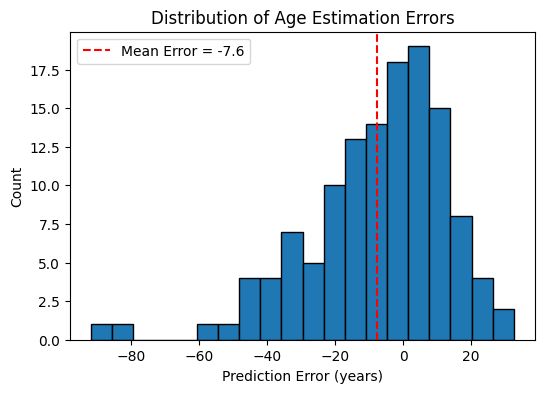

In [ ]:
# === 6. Compute Metrics & Plot Results ===

from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# 1) Compute MAE
mae = mean_absolute_error(y_true_age, y_pred_age)
print(f"Mean Absolute Error (MAE): {mae:.2f} years")

# 2) Scatter plot: True vs. Predicted Age
plt.figure(figsize=(6,6))
plt.scatter(y_true_age, y_pred_age, alpha=0.6)
plt.plot([min(y_true_age), max(y_true_age)],
         [min(y_true_age), max(y_true_age)],
         '--', linewidth=1, label='Ideal')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title(f'Age Estimation: MAE = {mae:.2f} yrs')
plt.legend()
plt.show()

# 3) Histogram of Errors
errors = np.array(y_pred_age) - np.array(y_true_age)
plt.figure(figsize=(6,4))
plt.hist(errors, bins=20, edgecolor='black')
plt.axvline(errors.mean(), color='red', linestyle='--',
            label=f'Mean Error = {errors.mean():.1f}')
plt.xlabel('Prediction Error (years)')
plt.ylabel('Count')
plt.title('Distribution of Age Estimation Errors')
plt.legend()
plt.show()

In [ ]:
# === A. Prepare aligned face images & true ages ===
from facenet_pytorch import MTCNN
from deepface import DeepFace
import torch
import numpy as np
import cv2

# 1) MTCNN for alignment at 224×224
mtcnn224 = MTCNN(image_size=224, margin=20, keep_all=False, device='cpu').eval()

face_imgs, ages = [], []
for _, row in df.iterrows():
    # load & convert
    img = cv2.imread(row['img_path'])[:,:,::-1]

    # detect & align
    face_tensor = mtcnn224(img)            # [3×224×224] or None
    if face_tensor is None:
        continue
    # to NumPy H×W×3 in [0,255]
    face_np = (face_tensor.permute(1,2,0).numpy() * 255).astype(np.uint8)

    face_imgs.append(face_np)
    ages.append(row['true_age'])

face_imgs = np.stack(face_imgs)   # (N,224,224,3)
ages      = np.array(ages)        # (N,)
print(f"Aligned faces: {face_imgs.shape}, Ages: {ages.shape}")

Aligned faces: (127, 224, 224, 3), Ages: (127,)


In [ ]:
# === B. Build & freeze the DEX model ===
from deepface import DeepFace
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

# 1) Build the Dex age “client” under the facial_attribute task
age_client = DeepFace.build_model(model_name="Age", task="facial_attribute")

# 2) Extract the underlying Keras model
age_model = age_client.model

# 3) Inspect the architecture
age_model.summary()

# 4) Freeze all but the last 3 layers (the regression head)
for layer in age_model.layers[:-3]:
    layer.trainable = False

# 5) Compile with MAE loss & metric
age_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=MeanAbsoluteError(),
    metrics=[MeanAbsoluteError()]
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_input (Inpu  [(None, 224, 224, 3)]     0         
 tLayer)                                                         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 226, 226, 3)       0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 226, 226, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                             

In [ ]:
# === B-updated: Freeze early layers, unfreeze last conv block + head ===

# Build the model as before
age_client = DeepFace.build_model(model_name="Age", task="facial_attribute")
age_model  = age_client.model

# 1) Determine where to start unfreezing (e.g. at 'conv2d_12')
unfreeze_from = None
for idx, layer in enumerate(age_model.layers):
    if layer.name == "conv2d_12":
        unfreeze_from = idx
        break

# 2) Freeze all layers before that index, and unfreeze from there on
for idx, layer in enumerate(age_model.layers):
    layer.trainable = (idx >= unfreeze_from)

# 3) Re-compile with the same MAE setup
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses     import MeanAbsoluteError

age_model.compile(
    optimizer=Adam(learning_rate=1e-5),   # lower LR since more layers are trainable
    loss=MeanAbsoluteError(),
    metrics=[MeanAbsoluteError()]
)

# 4) Check trainable params increased
import tensorflow as tf
trainable = sum(tf.keras.backend.count_params(w) for w in age_model.trainable_weights)
total     = sum(tf.keras.backend.count_params(w) for w in age_model.weights)
print(f"Trainable parameters: {trainable:,} / {total:,}")

Trainable parameters: 122,319,461 / 134,674,341


In [ ]:
# === C. Train-Validation Split & Fine-Tune ===
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming you have `face_imgs` (N×224×224×3) and `ages` (N,) from Part A:

# 1) Prepare inputs and labels
X = np.array(face_imgs, dtype='float32') / 255.0   # normalize to [0,1]
y = np.array(ages, dtype='float32')

# 2) Split into train and validation sets (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training on {len(X_train)} images, validating on {len(X_val)} images")

# 3) Fine-tune for a few epochs
history = age_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=8
)

Training on 101 images, validating on 26 images
Epoch 1/5
13/13 [==============================] - 183s 14s/step - loss: 43.4713 - mean_absolute_error: 43.2711 - val_loss: 36.0632 - val_mean_absolute_error: 36.2182
Epoch 2/5
13/13 [==============================] - 178s 14s/step - loss: 43.4713 - mean_absolute_error: 42.8516 - val_loss: 36.0632 - val_mean_absolute_error: 36.2182
Epoch 3/5
13/13 [==============================] - 187s 15s/step - loss: 43.4713 - mean_absolute_error: 43.0420 - val_loss: 36.0632 - val_mean_absolute_error: 36.2182
Epoch 4/5
13/13 [==============================] - 180s 14s/step - loss: 43.4713 - mean_absolute_error: 43.4309 - val_loss: 36.0632 - val_mean_absolute_error: 36.2182
Epoch 5/5
13/13 [==============================] - 182s 14s/step - loss: 43.4713 - mean_absolute_error: 43.9963 - val_loss: 36.0632 - val_mean_absolute_error: 36.2182


Predicted ages for 127 images (no training)
Baseline MAE (pre-trained only): 15.85 years


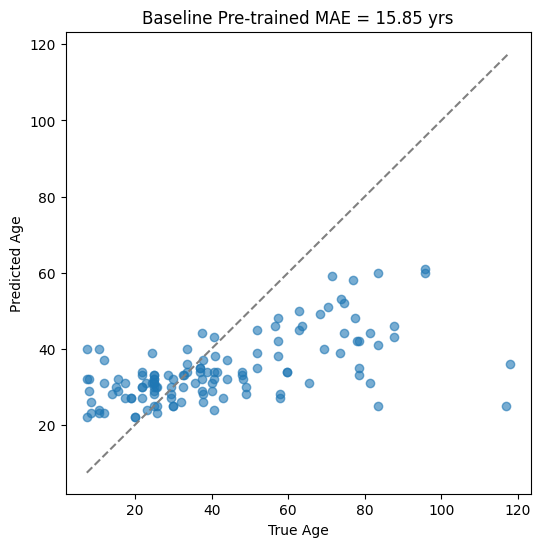

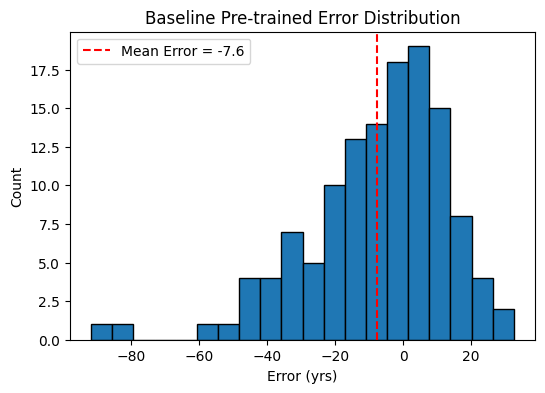

In [ ]:
# === Pre-trained Age Prediction Only ===

y_true_age, y_pred_age = [], []

for _, row in df.iterrows():
    # 1) Read & convert
    img_bgr = cv2.imread(row['img_path'])
    if img_bgr is None:
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2) DeepFace age prediction (pre-trained Dex model)
    analysis = DeepFace.analyze(
        img_rgb,
        actions=['age'],
        detector_backend='opencv',
        enforce_detection=False
    )
    # handle list output
    age_pred = analysis[0]['age'] if isinstance(analysis, list) else analysis['age']

    y_pred_age.append(age_pred)
    y_true_age.append(row['true_age'])

print(f"Predicted ages for {len(y_pred_age)} images (no training)")

# === Metrics & Plots ===
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

mae = mean_absolute_error(y_true_age, y_pred_age)
print(f"Baseline MAE (pre-trained only): {mae:.2f} years")

# Scatter
plt.figure(figsize=(6,6))
plt.scatter(y_true_age, y_pred_age, alpha=0.6)
plt.plot([min(y_true_age), max(y_true_age)],
         [min(y_true_age), max(y_true_age)],
         '--', color='gray')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title(f'Baseline Pre-trained MAE = {mae:.2f} yrs')
plt.show()

# Error histogram
errors = np.array(y_pred_age) - np.array(y_true_age)
plt.figure(figsize=(6,4))
plt.hist(errors, bins=20, edgecolor='black')
plt.axvline(errors.mean(), color='red', linestyle='--',
            label=f'Mean Error = {errors.mean():.1f}')
plt.xlabel('Error (yrs)')
plt.ylabel('Count')
plt.title('Baseline Pre-trained Error Distribution')
plt.legend()
plt.show()

Calibration slope (a): 1.7466, intercept (b): -18.11
MAE before calibration: 15.85 yrs
MAE after  calibration: 13.89 yrs


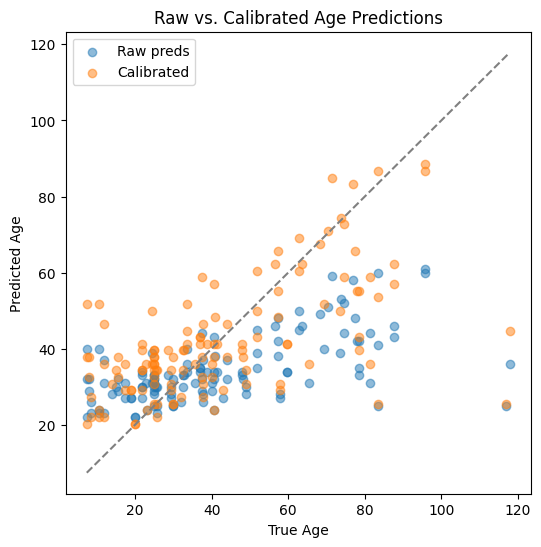

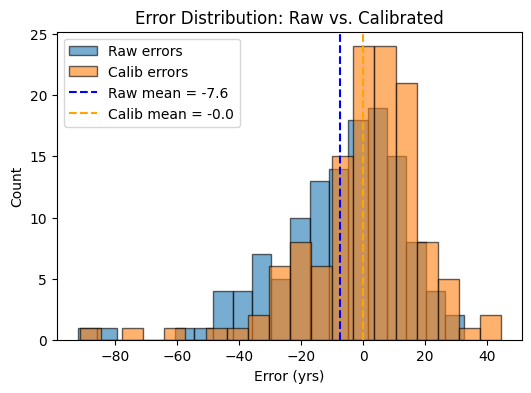

In [ ]:
# === E. Linear Calibration ===
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# 1) Prepare data
y_true = np.array(y_true_age)             # shape (N,)
y_pred = np.array(y_pred_age).reshape(-1,1)  # shape (N,1)

# 2) Fit linear regression: true_age = a * pred_age + b
calib = LinearRegression().fit(y_pred, y_true)
a, b = calib.coef_[0], calib.intercept_
print(f"Calibration slope (a): {a:.4f}, intercept (b): {b:.2f}")

# 3) Apply calibration
y_pred_calib = calib.predict(y_pred)

# 4) Compute MAE before & after
mae_before = mean_absolute_error(y_true, y_pred.flatten())
mae_after  = mean_absolute_error(y_true, y_pred_calib)
print(f"MAE before calibration: {mae_before:.2f} yrs")
print(f"MAE after  calibration: {mae_after:.2f} yrs")

# 5) Scatter plot: true vs. raw & calibrated
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred,      alpha=0.5, label='Raw preds')
plt.scatter(y_true, y_pred_calib,alpha=0.5, label='Calibrated')
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         '--', color='gray')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Raw vs. Calibrated Age Predictions')
plt.legend()
plt.show()

# 6) Error histograms
err_raw   = y_pred.flatten() - y_true
err_calib = y_pred_calib       - y_true

plt.figure(figsize=(6,4))
plt.hist(err_raw,   bins=20, alpha=0.6, label='Raw errors',   edgecolor='black')
plt.hist(err_calib, bins=20, alpha=0.6, label='Calib errors', edgecolor='black')
plt.axvline(err_raw.mean(),   color='blue',  linestyle='--', label=f'Raw mean = {err_raw.mean():.1f}')
plt.axvline(err_calib.mean(), color='orange',linestyle='--', label=f'Calib mean = {err_calib.mean():.1f}')
plt.xlabel('Error (yrs)')
plt.ylabel('Count')
plt.title('Error Distribution: Raw vs. Calibrated')
plt.legend()
plt.show()

Bin │   Slope (a)   │ Intercept (b) │ Count
--- │ ------------- │ ------------- │ -----
0-9 │      -0.0380 │         8.97 │     7
10-19 │      -0.0693 │        16.34 │    14
20-29 │       0.1043 │        21.53 │    29
30-39 │       0.2060 │        28.14 │    21
40-49 │      -0.1155 │        47.34 │    16
50-59 │      -0.1293 │        61.16 │    11
60-69 │      -0.0936 │        69.45 │     6
70-79 │      -0.1928 │        84.47 │    12
80-89 │       0.0528 │        81.87 │     7
90+ │      -0.6655 │       136.83 │     4

Overall MAE before calibration: 15.85 yrs
Overall MAE after  calibration: 2.19 yrs


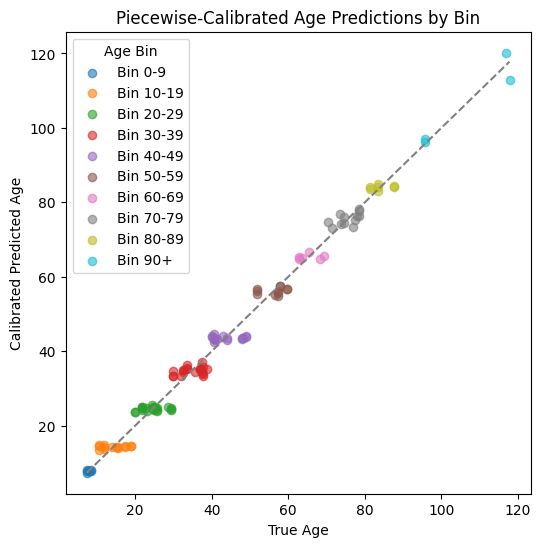

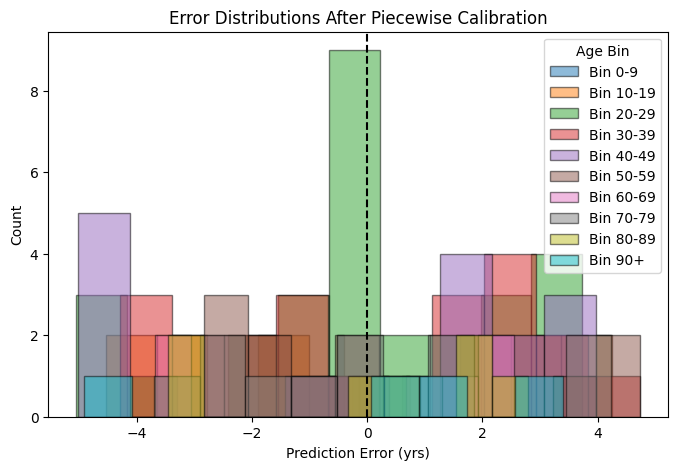

In [ ]:
# === F. Piecewise Linear Calibration by Age Bin ===
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# 1) Build a DataFrame with true age, raw prediction, and age_bin
df_calib = pd.DataFrame({
    'true_age': y_true_age,
    'pred_age': y_pred_age,
    'age_bin': df['age_bin'].values  # baseline predicted all 127 images in order
})

# 2) Fit a separate LinearRegression per bin
calibrators = {}
df_calib['pred_calib'] = np.nan

for bin_label, group in df_calib.groupby('age_bin'):
    X = group['pred_age'].values.reshape(-1,1)
    y = group['true_age'].values
    lr = LinearRegression().fit(X, y)
    calibrators[bin_label] = (lr.coef_[0], lr.intercept_)
    df_calib.loc[group.index, 'pred_calib'] = lr.predict(X)

# 3) Print calibration parameters per bin
print("Bin │   Slope (a)   │ Intercept (b) │ Count")
print("--- │ ------------- │ ------------- │ -----")
for bin_label, (a,b) in calibrators.items():
    count = len(df_calib[df_calib['age_bin']==bin_label])
    print(f"{bin_label:<3} │ {a:>12.4f} │ {b:>12.2f} │ {count:>5}")

# 4) Compute MAE before & after
mae_raw    = mean_absolute_error(df_calib['true_age'], df_calib['pred_age'])
mae_piece  = mean_absolute_error(df_calib['true_age'], df_calib['pred_calib'])
print(f"\nOverall MAE before calibration: {mae_raw:.2f} yrs")
print(f"Overall MAE after  calibration: {mae_piece:.2f} yrs")

# 5) Scatter plot of true vs. piecewise-calibrated predictions
plt.figure(figsize=(6,6))
for bin_label, group in df_calib.groupby('age_bin'):
    plt.scatter(group['true_age'], group['pred_calib'], label=f"Bin {bin_label}", alpha=0.6)
plt.plot([df_calib.true_age.min(), df_calib.true_age.max()],
         [df_calib.true_age.min(), df_calib.true_age.max()],
         '--', color='gray')
plt.xlabel('True Age')
plt.ylabel('Calibrated Predicted Age')
plt.title('Piecewise-Calibrated Age Predictions by Bin')
plt.legend(title='Age Bin')
plt.show()

# 6) Histogram of errors per bin
plt.figure(figsize=(8,5))
for bin_label, group in df_calib.groupby('age_bin'):
    errors = group['pred_calib'] - group['true_age']
    plt.hist(errors, bins=10, alpha=0.5, label=f"Bin {bin_label}", edgecolor='black')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Prediction Error (yrs)')
plt.ylabel('Count')
plt.title('Error Distributions After Piecewise Calibration')
plt.legend(title='Age Bin')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# Prepare df_calib again
df_calib = pd.DataFrame({
    'true_age': y_true_age,
    'pred_age': y_pred_age,
    'age_bin': df['age_bin'].values
})
n = len(df_calib)

# Array to hold CV predictions
cv_preds = np.zeros(n)

# Per-bin LOOCV
bin_maes = {}
for bin_label, idxs in df_calib.groupby('age_bin').groups.items():
    bin_idxs = list(idxs)
    bin_true = df_calib.loc[bin_idxs, 'true_age']
    bin_pred = df_calib.loc[bin_idxs, 'pred_age']

    preds = []
    for i in bin_idxs:
        # training set = all other indices in this bin
        train_idxs = [j for j in bin_idxs if j != i]
        X_train = df_calib.loc[train_idxs, 'pred_age'].values.reshape(-1,1)
        y_train = df_calib.loc[train_idxs, 'true_age'].values

        # if only one sample, skip calibration
        if len(train_idxs) < 2:
            pred_i = df_calib.at[i, 'pred_age']
        else:
            lr = LinearRegression().fit(X_train, y_train)
            pred_i = lr.predict([[df_calib.at[i, 'pred_age']]])[0]

        cv_preds[i] = pred_i
        preds.append(pred_i)

    # per-bin MAE
    bin_maes[bin_label] = mean_absolute_error(
        df_calib.loc[bin_idxs, 'true_age'], preds
    )

# Overall CV MAE
cv_mae = mean_absolute_error(df_calib['true_age'], cv_preds)

# Report
print(f"Overall LOOCV MAE after piecewise calibration: {cv_mae:.2f} yrs\n")
print("Per‐bin LOOCV MAEs:")
print("Bin     Count    CV MAE")
for bin_label, mae in bin_maes.items():
    count = len(df_calib[df_calib['age_bin']==bin_label])
    print(f"{bin_label:6}   {count:3d}     {mae:.2f}")

Overall LOOCV MAE after piecewise calibration: 2.66 yrs

Per‐bin LOOCV MAEs:
Bin     Count    CV MAE
0-9        7     0.45
10-19     14     3.15
20-29     29     1.93
30-39     21     2.74
40-49     16     3.55
50-59     11     2.67
60-69      6     3.87
70-79     12     2.24
80-89      7     2.80
90+        4     5.33


Predicted ages for 127 images
MAE on raw resized images: 11.90 years


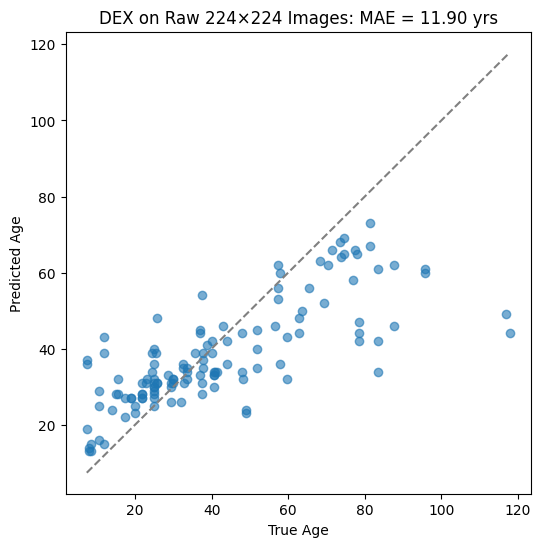

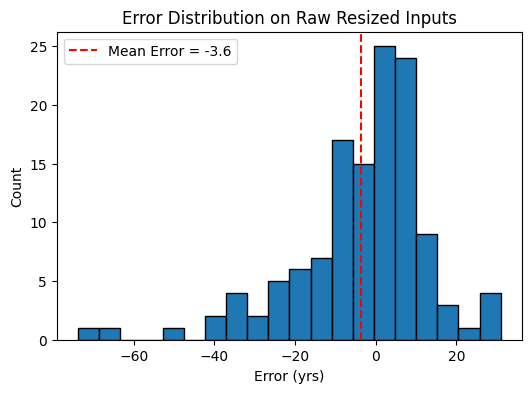

In [ ]:
# === Raw resized inference on original images ===
from deepface import DeepFace
import cv2
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

y_true, y_pred = [], []

for _, row in df.iterrows():
    # 1) Load & RGB-convert
    img = cv2.imread(row['img_path'])
    if img is None:
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2) Resize entire image to 224×224
    img_resized = cv2.resize(img_rgb, (224, 224))

    # 3) DeepFace age predict (skip internal detection)
    analysis = DeepFace.analyze(
        img_resized,
        actions=['age'],
        detector_backend='skip',      # no detection step
        enforce_detection=False,
        align=False                   # no alignment
    )
    age_est = analysis[0]['age'] if isinstance(analysis, list) else analysis['age']

    y_pred.append(age_est)
    y_true.append(row['true_age'])

print(f"Predicted ages for {len(y_pred)} images")

# === Compute MAE & visualize ===
mae_raw_resized = mean_absolute_error(y_true, y_pred)
print(f"MAE on raw resized images: {mae_raw_resized:.2f} years")

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true),max(y_true)], [min(y_true),max(y_true)],
         '--', color='gray')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title(f'DEX on Raw 224×224 Images: MAE = {mae_raw_resized:.2f} yrs')
plt.show()

errors = np.array(y_pred) - np.array(y_true)
plt.figure(figsize=(6,4))
plt.hist(errors, bins=20, edgecolor='black')
plt.axvline(errors.mean(), color='red', linestyle='--',
            label=f'Mean Error = {errors.mean():.1f}')
plt.xlabel('Error (yrs)')
plt.ylabel('Count')
plt.title('Error Distribution on Raw Resized Inputs')
plt.legend()
plt.show()

In [ ]:
import random

# Ensure reproducibility
random.seed(42)

train_imgs, train_labels = [], []
test_imgs,  test_labels  = [], []

for identity, group in df.groupby('identity'):
    paths = group['img_path'].tolist()
    # pick one at random for test
    test_path = random.choice(paths)
    for p in paths:
        if p == test_path:
            test_imgs.append(p)
            test_labels.append(identity)
        else:
            train_imgs.append(p)
            train_labels.append(identity)

print(f"Training samples: {len(train_imgs)} | Test samples: {len(test_imgs)}")

Training samples: 79 | Test samples: 48


In [ ]:
!pip install facenet-pytorch insightface deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 90.9 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp311-cp311-linux_x86_64.whl size=1060435 sha256=c9ecfa628e32de92fe58747b4f67e20a0cfb4e168ad3704c354811c8bf984033
  Stored in directory: /root/.cache/pip/wheels/27/d8/22/f52d858d16cd06e7b2e6aad34a1777dcfaf000be833bbf8146
Successfully built insightface


In [ ]:
from deepface import DeepFace
emb = DeepFace.represent(img, model_name='ArcFace')  # or 'Facenet'

In [ ]:
import cv2
import numpy as np

def augment_image(img_bgr):
    aug = [img_bgr]
    h, w = img_bgr.shape[:2]
    # horizontal flip
    aug.append(cv2.flip(img_bgr, 1))
    # rotations ±10°
    for angle in (10, -10):
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
        aug.append(cv2.warpAffine(img_bgr, M, (w, h)))
    # brightness jitter
    for factor in (1.2, 0.8):
        hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
        hsv[...,2] = np.clip(hsv[...,2] * factor, 0, 255)
        aug.append(cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR))
    return aug

# Build augmented lists
aug_train_imgs, aug_train_labels = [], []
for img_path, lbl in zip(train_imgs, train_labels):
    img = cv2.imread(img_path)
    for variant in augment_image(img):
        aug_train_imgs.append(variant)
        aug_train_labels.append(lbl)

print(f"Augmented training samples: {len(aug_train_imgs)}")

Augmented training samples: 474


🎯 FaceNet KNN Accuracy: 25.00%
🎯 ArcFace KNN Accuracy:  10.42%


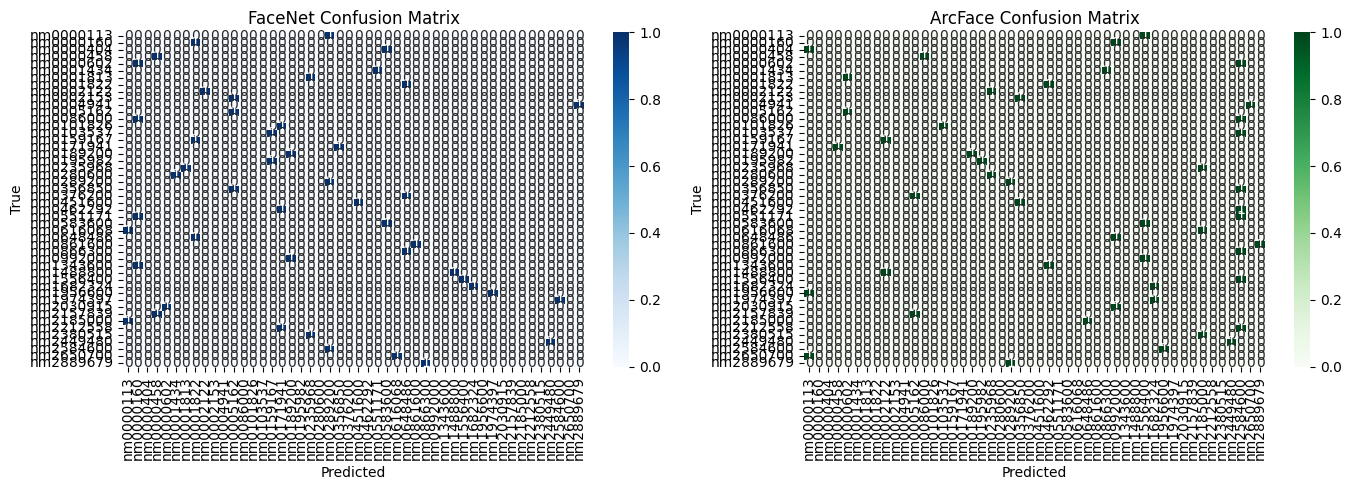

In [ ]:
from deepface import DeepFace
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Embedding helpers using DeepFace.represent
def embed_deepface(img_bgr, model_name, input_size):
    # Resize directly (no face-detection)
    img_rgb = cv2.cvtColor(cv2.resize(img_bgr, input_size), cv2.COLOR_BGR2RGB)
    rep = DeepFace.represent(
        img_rgb,
        model_name=model_name,
        enforce_detection=False,
        detector_backend='skip',
        align=False
    )
    # DeepFace.represent returns a list of dicts; take the first
    return np.array(rep[0]['embedding'])

# 2) Compute embeddings for augmented training set
#    (assuming aug_train_imgs, aug_train_labels exist)
X_train_fnet = [embed_deepface(img, 'Facenet',  (160,160)) for img in aug_train_imgs]
X_train_arc  = [embed_deepface(img, 'ArcFace',  (224,224)) for img in aug_train_imgs]

# 3) Compute embeddings for test set
test_bgrs     = [cv2.imread(p) for p in test_imgs]
X_test_fnet   = [embed_deepface(img, 'Facenet', (160,160)) for img in test_bgrs]
X_test_arc    = [embed_deepface(img, 'ArcFace', (224,224)) for img in test_bgrs]

# 4) Train & evaluate KNN classifiers

knn_fnet = KNeighborsClassifier(n_neighbors=3).fit(X_train_fnet, aug_train_labels)
pred_fnet = knn_fnet.predict(X_test_fnet)
acc_fnet  = accuracy_score(test_labels, pred_fnet)

knn_arc  = KNeighborsClassifier(n_neighbors=3).fit(X_train_arc, aug_train_labels)
pred_arc  = knn_arc.predict(X_test_arc)
acc_arc   = accuracy_score(test_labels, pred_arc)

print(f"🎯 FaceNet KNN Accuracy: {acc_fnet:.2%}")
print(f"🎯 ArcFace KNN Accuracy:  {acc_arc:.2%}")

# 5) Confusion matrices
ids      = sorted(df['identity'].unique())
cm_fnet  = confusion_matrix(test_labels, pred_fnet, labels=ids)
cm_arc   = confusion_matrix(test_labels, pred_arc,  labels=ids)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.heatmap(cm_fnet, xticklabels=ids, yticklabels=ids, annot=True, fmt='d', cmap='Blues')
plt.title('FaceNet Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')

plt.subplot(1,2,2)
sns.heatmap(cm_arc, xticklabels=ids, yticklabels=ids, annot=True, fmt='d', cmap='Greens')
plt.title('ArcFace Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
print("hi")

hi


In [ ]:
# 0) (In Colab) pip install
#!pip install --upgrade deepface scikit-learn matplotlib seaborn

# 1) Imports & Load CSV
import os, random, cv2, numpy as np, pandas as pd
from deepface import DeepFace
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics    import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

BASE_DIR = '/content/drive/MyDrive/icici_w5-8'
df = pd.read_csv(os.path.join(BASE_DIR, 'imdb_images_metadata.csv'))
df['img_path'] = df['full_path'].apply(lambda p: os.path.join(BASE_DIR, p))

# 2) Split train/test (1 per identity held out)
random.seed(42)
train_imgs, train_labels = [], []
test_imgs,  test_labels  = [], []
for ident, grp in df.groupby('identity'):
    paths = grp['img_path'].tolist()
    test_p = random.choice(paths)
    for p in paths:
        if p == test_p:
            test_imgs.append(p);  test_labels.append(ident)
        else:
            train_imgs.append(p); train_labels.append(ident)

print(f"Train: {len(train_imgs)} images; Test: {len(test_imgs)} images")

# 3) Augmentation (no flips; ±5° rotates; brightness ±10%; zooms)
def augment_image(img_bgr):
    h,w = img_bgr.shape[:2]
    variants = [img_bgr]
    # rotations
    for ang in (5, -5):
        M = cv2.getRotationMatrix2D((w//2,h//2), ang, 1.0)
        variants.append(cv2.warpAffine(img_bgr, M, (w,h)))
    # brightness
    for f in (1.1, 0.9):
        hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
        hsv[...,2] = np.clip(hsv[...,2]*f, 0, 255)
        variants.append(cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR))
    # zoom in/out
    for scale in (0.9,1.1):
        nh, nw = int(h*scale), int(w*scale)
        resized = cv2.resize(img_bgr, (nw,nh))
        if scale>1:
            y0,x0 = (nh-h)//2, (nw-w)//2
            variants.append(resized[y0:y0+h, x0:x0+w])
        else:
            canvas = np.zeros_like(img_bgr)
            y0,x0 = (h-nh)//2, (w-nw)//2
            canvas[y0:y0+nh, x0:x0+nw] = resized
            variants.append(canvas)
    return variants

aug_imgs, aug_labels = [], []
for p,lbl in zip(train_imgs, train_labels):
    img = cv2.imread(p)
    for v in augment_image(img):
        aug_imgs.append(v)
        aug_labels.append(lbl)
print(f"Augmented train size: {len(aug_imgs)}")

# 4) Embedding helper via DeepFace.represent
def embed_df(img_bgr, model_name, size):
    resized = cv2.resize(img_bgr, size)
    rgb     = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    rep     = DeepFace.represent(rgb,
                model_name=model_name,
                enforce_detection=False,
                detector_backend='skip',
                align=False)
    return np.array(rep[0]['embedding'])

# 5) Compute embeddings
X_train = {
  'Facenet': [embed_df(img,'Facenet',(160,160)) for img in aug_imgs],
  'ArcFace': [embed_df(img,'ArcFace',(224,224)) for img in aug_imgs]
}
X_test = {
  'Facenet': [embed_df(cv2.imread(p),'Facenet',(160,160)) for p in test_imgs],
  'ArcFace': [embed_df(cv2.imread(p),'ArcFace',(224,224)) for p in test_imgs]
}

# 6) KNN sweep (cosine metric)
best = {}
for model,size in [('Facenet',(160,160)),('ArcFace',(224,224))]:
    best_acc,best_k = 0,None
    for k in [1,3,5,7,9]:
        knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
        knn.fit(X_train[model], aug_labels)
        preds = knn.predict(X_test[model])
        acc   = accuracy_score(test_labels, preds)
        print(f"{model} k={k} → {acc:.2%}")
        if acc>best_acc:
            best_acc,best_k = acc,k
    best[model]=(best_k,best_acc)
print("Best K:", best)

# 7) One‐vs‐Many verification
def cos_sim(a,b): return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

verif = {}
for model,size in [('Facenet',(160,160)),('ArcFace',(224,224))]:
    # build one template per identity (avg of original train imgs)
    refs = {}
    for ident in set(train_labels):
        paths = [p for p,l in zip(train_imgs,train_labels) if l==ident]
        embs  = [embed_df(cv2.imread(p),model,size) for p in paths]
        refs[ident] = np.mean(embs,axis=0)
    # test by picking highest‐similarity identity
    correct=0
    for p,true in zip(test_imgs,test_labels):
        emb = embed_df(cv2.imread(p),model,size)
        pred= max(refs, key=lambda i: cos_sim(emb,refs[i]))
        correct += (pred==true)
    acc = correct/len(test_imgs)
    verif[model]=acc
    print(f"{model} 1:N verification acc: {acc:.2%}")

# 8) Summary heatmaps (optional)
# ids = sorted(df['identity'].unique())
# for model in ('Facenet','ArcFace'):
#     knn = KNeighborsClassifier(n_neighbors=best[model][0], metric='cosine')
#     knn.fit(X_train[model], aug_labels)
#     #cm = confusion_matrix(test_labels, knn.predict(X_test[model]), labels=ids)
#     plt.figure(figsize=(6,5))
#     #sns.heatmap(cm, annot=True, fmt='d', xticklabels=ids, yticklabels=ids)
#     plt.title(f"{model} (k={best[model][0]}) Confusion")
#     plt.xlabel("Predicted"); plt.ylabel("True")
#     plt.show()

Train: 79 images; Test: 48 images
Augmented train size: 553
Facenet k=1 → 33.33%
Facenet k=3 → 27.08%
Facenet k=5 → 31.25%
Facenet k=7 → 33.33%
Facenet k=9 → 27.08%
ArcFace k=1 → 27.08%
ArcFace k=3 → 16.67%
ArcFace k=5 → 16.67%
ArcFace k=7 → 16.67%
ArcFace k=9 → 16.67%
Best K: {'Facenet': (1, 0.3333333333333333), 'ArcFace': (1, 0.2708333333333333)}
Facenet 1:N verification acc: 31.25%
ArcFace 1:N verification acc: 18.75%


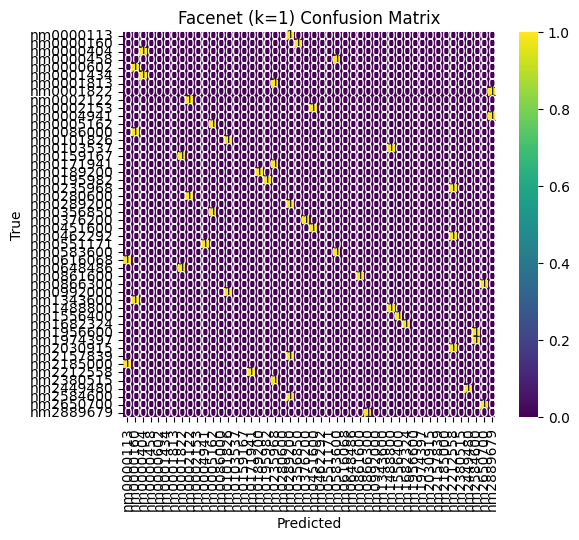

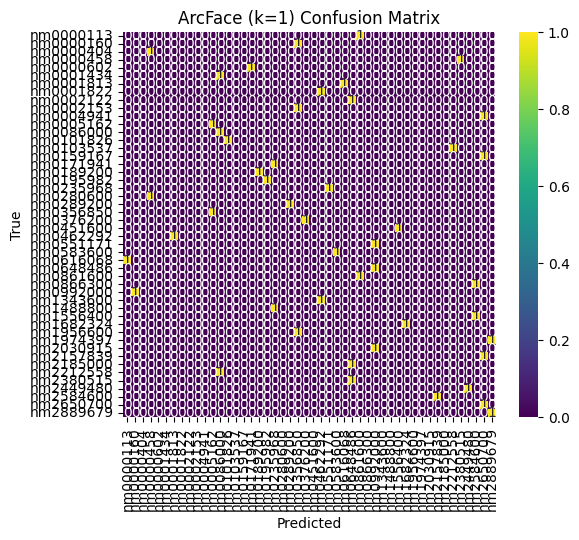

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Build the list of identities from your train/test labels
ids = sorted(set(aug_labels + test_labels))

for model in ('Facenet', 'ArcFace'):
    k_best = best[model][0]
    knn = KNeighborsClassifier(n_neighbors=k_best, metric='cosine')
    knn.fit(X_train[model], aug_labels)
    preds = knn.predict(X_test[model])

    cm = confusion_matrix(test_labels, preds, labels=ids)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=ids, yticklabels=ids, cmap='viridis')
    plt.title(f"{model} (k={k_best}) Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [ ]:
!pip install --upgrade deepface scikit-learn matplotlib seaborn

Selected k=1 with CV=98.31%
KNN Test Acc:      31.25%
AdaBoost Test Acc: 16.67%


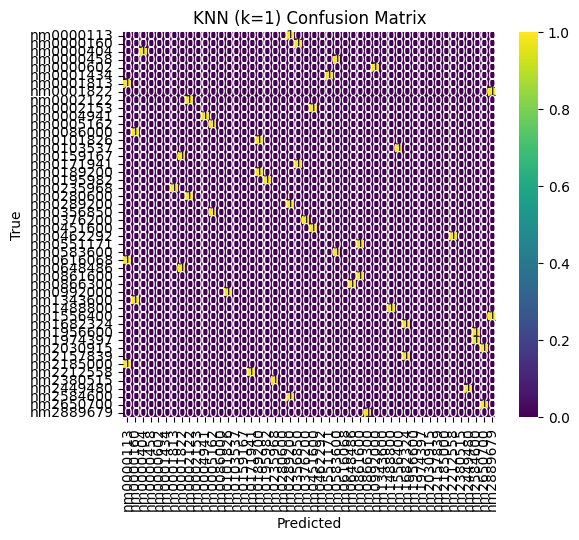

In [ ]:
import os, random, cv2, numpy as np, pandas as pd
from deepface import DeepFace
from sklearn.preprocessing     import normalize
from sklearn.model_selection   import StratifiedKFold
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.ensemble          import AdaBoostClassifier
from sklearn.calibration       import CalibratedClassifierCV
from sklearn.metrics           import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load metadata
BASE_DIR = '/content/drive/MyDrive/icici_w5-8'
df = pd.read_csv(os.path.join(BASE_DIR, 'imdb_images_metadata.csv'))
df['img_path'] = df['full_path'].apply(lambda p: os.path.join(BASE_DIR, p))

# 2) Split one image per identity into test, rest for train
random.seed(42)
train_imgs, train_labels, test_imgs, test_labels = [], [], [], []
for ident, grp in df.groupby('identity'):
    paths = grp['img_path'].tolist()
    test_p = random.choice(paths)
    for p in paths:
        if p==test_p:
            test_imgs.append(p);  test_labels.append(ident)
        else:
            train_imgs.append(p); train_labels.append(ident)

# 3) Augmentation: just ±5° rotations
def augment(img):
    h,w = img.shape[:2]
    outs = [img]
    for ang in (5,-5):
        M = cv2.getRotationMatrix2D((w//2,h//2), ang, 1.0)
        outs.append(cv2.warpAffine(img, M, (w,h)))
    return outs

aug_imgs, aug_labels = [], []
for p,lbl in zip(train_imgs,train_labels):
    img = cv2.imread(p)
    for v in augment(img):
        aug_imgs.append(v); aug_labels.append(lbl)

# 4) Embedding with DeepFace.represent (Facenet)
def embed(img_bgr):
    r = cv2.resize(img_bgr,(160,160))
    rgb = cv2.cvtColor(r, cv2.COLOR_BGR2RGB)
    rep = DeepFace.represent(
        rgb,
        model_name='Facenet',
        enforce_detection=False,
        detector_backend='skip',
        align=False
    )
    return np.array(rep[0]['embedding'])

# 5) Build & normalize embeddings
X_train = normalize(np.vstack([embed(i) for i in aug_imgs]), norm='l2')
y_train = np.array(aug_labels)
X_test  = normalize(np.vstack([embed(cv2.imread(p)) for p in test_imgs]), norm='l2')
y_test  = np.array(test_labels)

# 6) 3-fold CV to pick k
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
best_acc, best_k = 0, 1
for k in (1,3,5):
    scores = []
    for ti,vi in cv.split(X_train,y_train):
        knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
        knn.fit(X_train[ti], y_train[ti])
        scores.append(accuracy_score(y_train[vi], knn.predict(X_train[vi])))
    m = np.mean(scores)
    if m>best_acc:
        best_acc,best_k = m,k
print(f"Selected k={best_k} with CV={best_acc:.2%}")

# 7) Train final KNN and calibrated AdaBoost
knn = KNeighborsClassifier(n_neighbors=best_k, metric='cosine')
knn.fit(X_train, y_train)

adb = AdaBoostClassifier(n_estimators=100, learning_rate=1.0)
cal_adb = CalibratedClassifierCV(adb, cv=cv, method='sigmoid')
cal_adb.fit(X_train, y_train)

# 8) Evaluate
print("KNN Test Acc:     ", f"{accuracy_score(y_test, knn.predict(X_test)):.2%}")
print("AdaBoost Test Acc:", f"{accuracy_score(y_test, cal_adb.predict(X_test)):.2%}")

# 9) Confusion matrix for KNN
ids = sorted(set(y_test))
cm = confusion_matrix(y_test, knn.predict(X_test), labels=ids)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=ids, yticklabels=ids, cmap='viridis')
plt.title(f"KNN (k={best_k}) Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

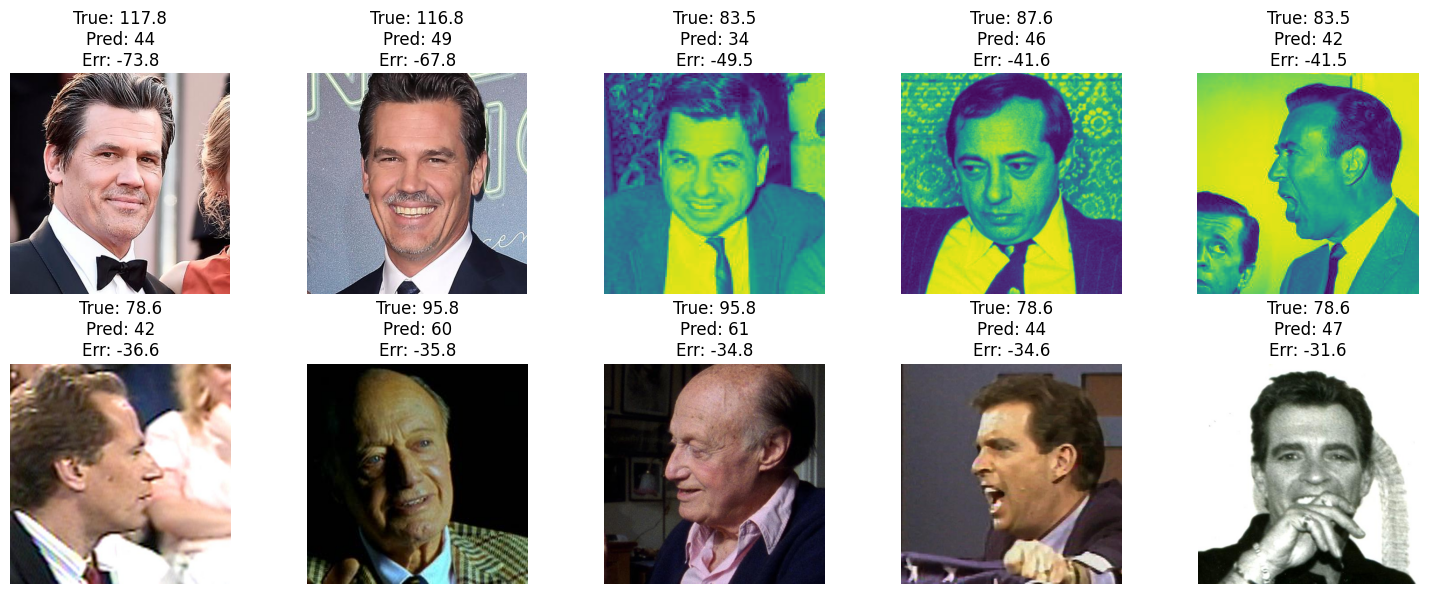

In [ ]:
# 1) Make sure you have y_pred and y_true aligned to df
#    For example, if you did:
#      y_true, y_pred = [], []
#      for _, row in df.iterrows():
#          ... compute age_est ...
#          y_pred.append(age_est)
#          y_true.append(row['true_age'])
#
#    Then y_pred[i] corresponds to df.iloc[i].

# 2) Add those lists as DataFrame columns:
df['pred_age'] = y_pred
df['true_age'] = df['age']          # or however you stored your ground-truth

# 3) Compute raw and absolute errors:
df['error']     = df['pred_age'] - df['true_age']
df['abs_error'] = df['error'].abs()

# 4) Flag large‐error cases:
mae_baseline = df['abs_error'].mean()
threshold    = 2 * mae_baseline
high_err     = df[df['abs_error'] > threshold]

# 5) Inspect top offenders:
top10 = df.nlargest(10, 'abs_error')

# 6) Visual debugging:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,5, figsize=(15,6))
for ax, (_, row) in zip(axes.flatten(), top10.iterrows()):
    img = plt.imread(row['img_path'])
    ax.imshow(img); ax.axis('off')
    ax.set_title(f"True: {row['true_age']}\nPred: {row['pred_age']}\nErr: {row['error']:.1f}")
plt.tight_layout()
plt.show()

In [ ]:
# 1) Define your “high‐error” threshold
thr = df['abs_error'].quantile(0.90)

# 2) Filter the DataFrame
df_high = df[df['abs_error'] > thr]

# 3) Pick the columns you actually have
cols = ['filename','identity','true_age','pred_age','error','abs_error','photo_year','age']
print(df_high[cols].sort_values('abs_error', ascending=False).head(10))

                                       filename   identity  true_age  \
101   nm0101826_rm2106586112_1897-9-13_2015.jpg  nm0101826     117.8   
83    nm0101826_rm4259118592_1897-9-13_2014.jpg  nm0101826     116.8   
108   nm0001813_rm689801984_1925-12-13_2009.jpg  nm0001813      83.5   
105  nm0462292_rm3309940480_1924-12-12_2012.jpg  nm0462292      87.6   
75   nm0001813_rm1365674496_1925-12-13_2009.jpg  nm0001813      83.5   
72    nm0235968_rm2114429184_1933-12-9_2012.jpg  nm0235968      78.6   
100    nm0002153_rm381925632_1914-9-18_2010.jpg  nm0002153      95.8   
120    nm0002153_rm331593984_1914-9-18_2010.jpg  nm0002153      95.8   
70    nm0235968_rm2097651968_1933-12-9_2012.jpg  nm0235968      78.6   
88    nm0235968_rm1929879808_1933-12-9_2012.jpg  nm0235968      78.6   

     pred_age  error  abs_error  photo_year    age  
101        44  -73.8       73.8        2015  117.8  
83         49  -67.8       67.8        2014  116.8  
108        34  -49.5       49.5        2009   83

In [ ]:
from facenet_pytorch import MTCNN
import numpy as np
import cv2

# 1) Initialize MTCNN (CPU)
mtcnn = MTCNN(keep_all=False, device='cpu')

# 2) Run detector on every image and record the first face’s probability
scores = []
for p in df['img_path']:
    img = cv2.imread(p)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes, probs = mtcnn.detect(rgb)
    # probs is an array of shape [num_faces], take the first if present
    scores.append(probs[0] if (probs is not None and len(probs)>0) else np.nan)

# 3) Add to DataFrame
df['face_score'] = scores

# 4) Now inspect high-error cases including face_score
thr    = df['abs_error'].quantile(0.90)
df_high = df[df['abs_error'] > thr]
cols = ['filename','identity','true_age','pred_age','error','abs_error','face_score']
print(df_high[cols].sort_values('abs_error', ascending=False).head(10))

KeyError: 'abs_error'

In [ ]:
# 0) First, inspect what’s in df
print(df.columns.tolist())

['filename', 'identity', 'birth_date', 'photo_year', 'age', 'age_bin', 'full_path', 'img_path', 'face_score']


In [ ]:
# 1) Attach your predictions to the DataFrame
#    — if your list of predictions is named y_pred_age use that;
#      otherwise substitute the correct variable (e.g. y_pred)
df['pred_age'] = y_pred_age    # or df['pred_age'] = y_pred

# 2) Define the ground-truth column
df['true_age'] = df['age']     # your CSV’s age column

# 3) Compute raw & absolute error
df['error']     = df['pred_age'] - df['true_age']
df['abs_error'] = df['error'].abs()

# 4) Look at your columns to confirm
print(df[['filename','true_age','pred_age','error','abs_error','face_score']].head())

                                    filename  true_age  pred_age  error  \
0  nm1343600_rm409832704_1978-12-20_2004.jpg      25.5        30    4.5   
1  nm1343600_rm207985152_1978-12-20_2003.jpg      24.5        31    6.5   
2  nm1343600_rm241539584_1978-12-20_2003.jpg      24.5        39   14.5   
3   nm0451600_rm3884361984_1955-3-7_2012.jpg      57.3        48   -9.3   
4   nm0451600_rm1547153152_1955-3-7_2012.jpg      57.3        38  -19.3   

   abs_error  face_score  
0        4.5    0.999869  
1        6.5    0.999982  
2       14.5    0.999838  
3        9.3    0.999989  
4       19.3    0.999920  


In [ ]:
# 5) Threshold at the 90th percentile
thr     = df['abs_error'].quantile(0.90)
df_high = df[df['abs_error'] > thr]

# 6) Display the worst 10 cases
cols = ['filename','identity','true_age','pred_age','error','abs_error','face_score']
print(df_high[cols]
        .sort_values('abs_error', ascending=False)
        .head(10))

                                       filename   identity  true_age  \
83    nm0101826_rm4259118592_1897-9-13_2014.jpg  nm0101826     116.8   
101   nm0101826_rm2106586112_1897-9-13_2015.jpg  nm0101826     117.8   
108   nm0001813_rm689801984_1925-12-13_2009.jpg  nm0001813      83.5   
98     nm0356850_rm825596672_1924-1-22_2005.jpg  nm0356850      81.4   
88    nm0235968_rm1929879808_1933-12-9_2012.jpg  nm0235968      78.6   
107  nm0462292_rm4165578496_1924-12-12_2012.jpg  nm0462292      87.6   
70    nm0235968_rm2097651968_1933-12-9_2012.jpg  nm0235968      78.6   
75   nm0001813_rm1365674496_1925-12-13_2009.jpg  nm0001813      83.5   
105  nm0462292_rm3309940480_1924-12-12_2012.jpg  nm0462292      87.6   
84     nm0356850_rm808819456_1924-1-22_2005.jpg  nm0356850      81.4   

     pred_age  error  abs_error  face_score  
83         25  -91.8       91.8    0.999147  
101        36  -81.8       81.8    1.000000  
108        25  -58.5       58.5    0.999490  
98         31  -50.4   

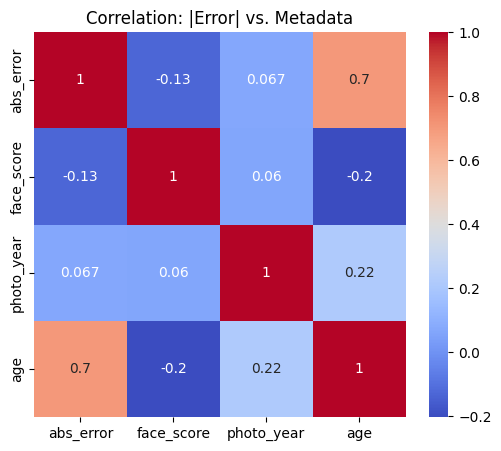

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 7) Correlation matrix among error, face_score, photo_year, and age
meta = df[['abs_error','face_score','photo_year','age']]
corr = meta.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation: |Error| vs. Metadata")
plt.show()

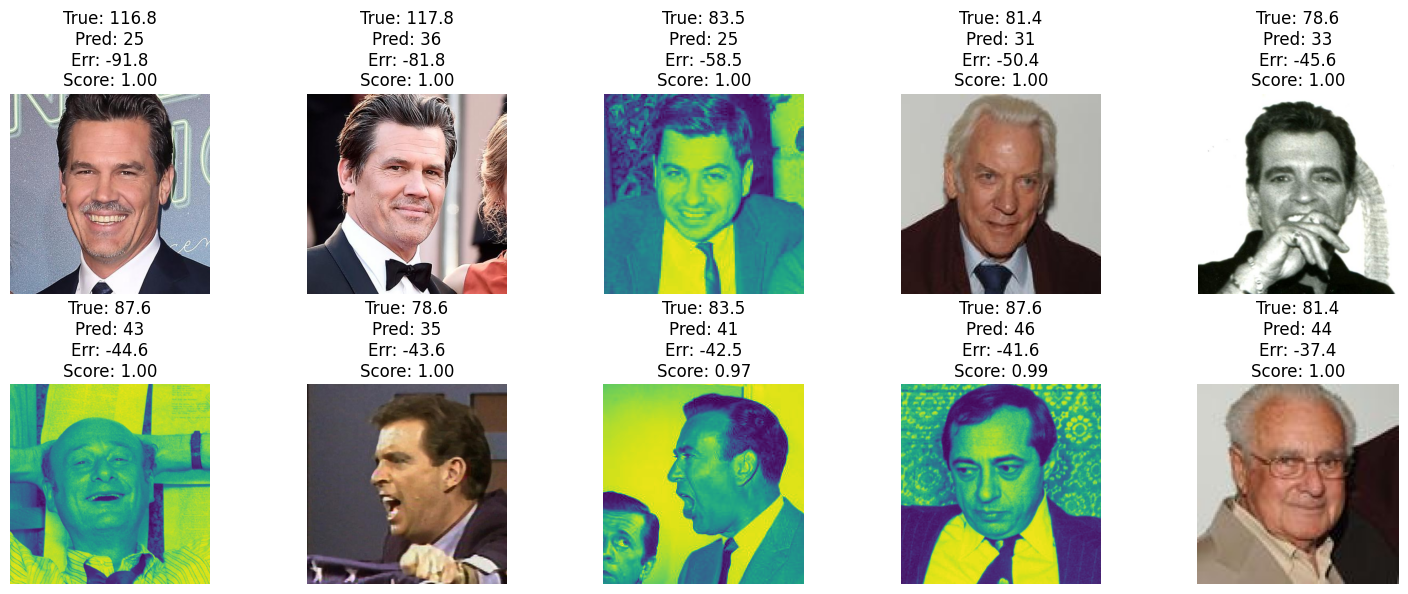

In [ ]:
fig, axes = plt.subplots(2,5, figsize=(15,6))
for ax, (_, row) in zip(axes.flatten(), df_high.nlargest(10,'abs_error').iterrows()):
    img = plt.imread(row['img_path'])
    ax.imshow(img); ax.axis('off')
    ax.set_title(f"True: {row['true_age']}\nPred: {row['pred_age']}\nErr: {row['error']:.1f}\nScore: {row['face_score']:.2f}")
plt.tight_layout()
plt.show()

In [ ]:
# Export the top-error rows for you to label “Cause”
df_high = df.nlargest(50, 'abs_error')   # pick top 50 for review
df_high[['filename','identity','true_age','pred_age','error','abs_error','face_score','photo_year','age_bin']] \
    .to_csv('/content/high_error_cases.csv', index=False)
print("Exported high_error_cases.csv – add a new column ‘Cause’ and save as high_error_annotated.csv")

Exported high_error_cases.csv – add a new column ‘Cause’ and save as high_error_annotated.csv


,age_bin,count,mean,median,std
0,0-9,7,21.285714,21.10,6.481108
1,10-19,14,14.900000,13.55,6.070990
2,20-29,29,5.313793,5.10,3.600766
3,30-39,21,4.276190,4.60,3.175989
4,40-49,16,11.537500,11.60,5.540623
5,50-59,11,18.454545,16.90,8.403495
6,60-69,6,21.883333,18.55,8.230047
7,70-79,12,29.208333,30.00,10.451660
8,80-89,7,42.628571,42.50,10.911265
9,90+,4,61.050000,58.80,30.015274


,face_score_bin,count,mean,median
0,low,0,NaN,NaN
1,medium,0,NaN,NaN
2,high,0,NaN,NaN
3,very_high,127,15.854331,12.1


,photo_year_bin,count,mean,median
0,"(1975, 1980]",3,19.966667,19.00
1,"(1980, 1985]",6,15.700000,14.40
2,"(1985, 1990]",2,1.900000,1.90
3,"(1990, 1995]",2,20.850000,20.85
4,"(1995, 2000]",4,17.750000,17.85
5,"(2000, 2005]",20,14.320000,9.55
6,"(2005, 2010]",43,15.597674,12.50
7,"(2010, 2015]",46,16.939130,9.55


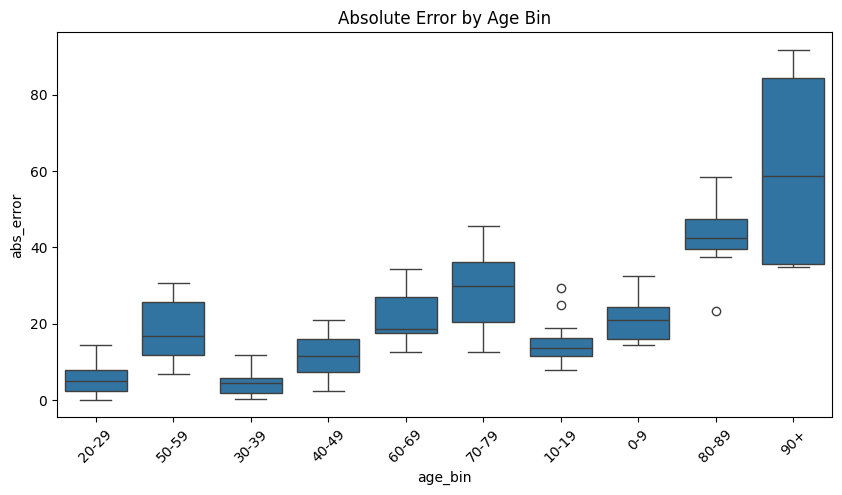

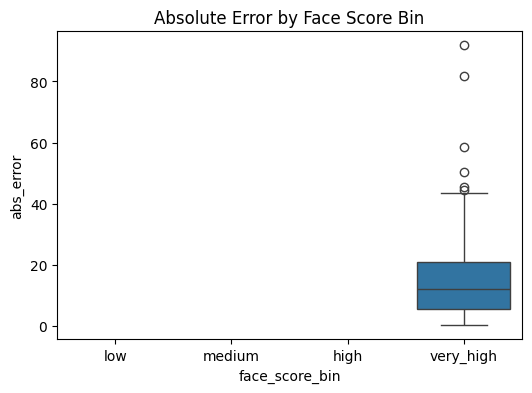

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# (Re)load your df with pred_age, true_age, error, abs_error, face_score, age_bin, photo_year

# 1) Summary by age_bin
summary_age = df.groupby('age_bin')['abs_error'] \
                .agg(count='count', mean='mean', median='median', std='std') \
                .reset_index()
display(summary_age)   # or use ace_tools.display_dataframe_to_user

# 2) Summary by face_score buckets
df['face_score_bin'] = pd.cut(df['face_score'],
                              bins=[0,0.5,0.7,0.85,1.0],
                              labels=['low','medium','high','very_high'])
summary_fs = df.groupby('face_score_bin')['abs_error'] \
               .agg(count='count', mean='mean', median='median') \
               .reset_index()
display(summary_fs)

# 3) Summary by photo_year bins (5-year intervals)
year_bins = list(range(df['photo_year'].min(),
                      df['photo_year'].max()+5, 5))
df['photo_year_bin'] = pd.cut(df['photo_year'], bins=year_bins)
summary_py = df.groupby('photo_year_bin')['abs_error'] \
               .agg(count='count', mean='mean', median='median') \
               .reset_index()
display(summary_py)

# 4) Boxplot of abs_error by age_bin
plt.figure(figsize=(10,5))
sns.boxplot(x='age_bin', y='abs_error', data=df)
plt.xticks(rotation=45)
plt.title('Absolute Error by Age Bin')
plt.show()

# 5) Boxplot of abs_error by face_score_bin
plt.figure(figsize=(6,4))
sns.boxplot(x='face_score_bin', y='abs_error', data=df)
plt.title('Absolute Error by Face Score Bin')
plt.show()

In [ ]:
print("hi")

hi
